# Road Sign Detection using Keras and OpenCv

## Team Members involved:

#### Prajwal Venkatesh 
#### Rahul K R
#### Sachin S
#### Sambit Sanyal

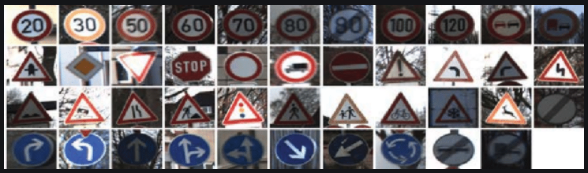

### You can get the dataset from this link 

https://drive.google.com/drive/folders/1VtcyQnf6HgbQzlCQeSrNbn4pWiMwjlew?usp=sharing 

##### signnames.csv – It has all the labels and their descriptors.
##### train.p – It contains all the training image pixel intensities along with the labels.
##### valid.p – It contains all the validation image pixel intensities along with the labels.
##### test.p – It contains all the testing image pixel intensities along with the labels.
The above files with extension .p are called pickle files, which are used to serialize objects into character streams. These can be deserialized and reused later by loading them using the pickle library in python.

Let’s implement a Convolutional Neural Network (CNN) using Keras in simple and easy-to-follow steps. A CNN consists of a series of Convolutional and Pooling layers in the Neural Network which map with the input to extract features. A Convolution layer will have many filters that are mainly used to detect the low-level features such as edges of a face. The Pooling layer does dimensionality reduction to decrease computation. Moreover, it also extracts the dominant features by ignoring the side pixels. To read more about CNNs, go to this link.



### Importing the libraries
We will be needing the following libraries. Make sure you install NumPy, Pandas, Keras, Matplotlib and OpenCV before implementing the following code.

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator 
import pickle 
import pandas as pd 
import random 
import cv2 

np.random.seed(0) 


#### Loading the dataset
Time to load the data. We will use pandas to load signnames.csv, and pickle to load the train, validation and test pickle files. After extraction of data, it is then split using the dictionary labels “features” and “labels”.

In [8]:
# Read data 
data = pd.read_csv("signnames.csv") 
df = data['SignName'].values.tolist()
num_classes = len(df)

with open('train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
X_train, y_train = train_data['features'], train_data['labels'] 
X_val, y_val = val_data['features'], val_data['labels'] 
X_test, y_test = test_data['features'], test_data['labels'] 

# Printing the shapes 
print(X_train.shape) 
print(X_val.shape) 
print(X_test.shape) 


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


#### Preprocessing the data using OpenCV
Preprocessing images before feeding into the model gives very accurate results as it helps in extracting the complex features of the image. OpenCV has some built-in functions like cvtColor() and equalizeHist() for this task. Follow the below steps for this task –

First, the images are converted to grayscale images for reducing computation using the cvtColor() function.
The equalizeHist() function increases the contrasts of the image by equalizing the intensities of the pixels by normalizing them with their nearby pixels.
At the end, we normalize the pixel values between 0 and 1 by dividing them by 255.

In [9]:

def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 

X_train = np.array(list(map(preprocessing, X_train))) 
X_val = np.array(list(map(preprocessing, X_val))) 
X_test = np.array(list(map(preprocessing, X_test))) 

X_train = X_train.reshape(34799, 32, 32, 1) 
X_val = X_val.reshape(4410, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 


#### Post Loading the data
After reshaping the arrays, it’s time to feed them into the model for training. But to increase the accuracy of our CNN model, we will involve one more step of generating augmented images using the ImageDataGenerator.

This is done to reduce overfitting the training data as getting more varied data will result in a better model. The value 0.1 is interpreted as 10%, whereas 10 is the degree of rotation. We are also converting the labels to categorical values, as we normally do.

In [10]:
datagen = ImageDataGenerator(width_shift_range = 0.1, 
                height_shift_range = 0.1, 
                zoom_range = 0.2, 
                shear_range = 0.1, 
                rotation_range = 10) 
datagen.fit(X_train) 

y_train = to_categorical(y_train, num_classes) 
y_val = to_categorical(y_val, num_classes) 
y_test = to_categorical(y_test, num_classes) 


#### Building the model
As we have 43 classes of images in the dataset, we are setting num_classes as 43. The model contains two Conv2D layers followed by one MaxPooling2D layer. This is done two times for the effective extraction of features, which is followed by the Dense layers. A dropout layer of 0.5 is added to avoid overfitting the data.

In [13]:
def cnn_model(): 
    model = Sequential() 
    model.add(Conv2D(60, (5, 5), 
                    input_shape =(32, 32, 1), 
                    activation ='relu')) 

    model.add(Conv2D(60, (5, 5), activation ='relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    
    model.add(Conv2D(30, (3, 3), activation ='relu')) 
    model.add(Conv2D(30, (3, 3), activation ='relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    
    model.add(Flatten()) 
    model.add(Dense(500, activation ='relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(num_classes, activation ='softmax')) 
    
    # Compile model 
    model.compile(Adam(lr = 0.001), 
                loss ='categorical_crossentropy', 
                metrics =['accuracy']) 
    return model 

model = cnn_model() 
history = model.fit_generator(datagen.flow(X_train, y_train, 
                            batch_size = 50), steps_per_epoch = 2000/5, 
                            epochs = 10, validation_data =(X_val, y_val), 
                            shuffle = 1) 

model.save('mymodel.hdf5')

with open('history.csv', 'w') as f: 
    history_df = pd.DataFrame(history.history).to_csv(f) 


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
400/400 [==============================] - 82s 204ms/step - loss: 2.4137 - accuracy: 0.3237 - val_loss: 0.7416 - val_accuracy: 0.7658
Epoch 2/10
400/400 [==============================] - 86s 214ms/step - loss: 0.9201 - accuracy: 0.7164 - val_loss: 0.2416 - val_accuracy: 0.9229
Epoch 3/10
400/400 [==============================] - 85s 213ms/step - loss: 0.5510 - accuracy: 0.8298 - val_loss: 0.1291 - val_accuracy: 0.9619
Epoch 4/10
400/400 [==============================] - 87s 218ms/step - loss: 0.4003 - accuracy: 0.8752 - val_loss: 0.1189 - val_accuracy: 0.9639
Epoch 5/10
400/400 [==============================] - 90s 224ms/step - loss: 0.3166 - accuracy: 0.9014 - val_loss: 0.0735 - val_accuracy: 0.9755
Epoch 6/10
400/400 [==============================] - 88s 219ms/step - loss: 0.2713 - accuracy: 0.9150 - val_loss: 0.0715 - val_accuracy: 0.9812
Epoch 7/10
400/400 [==============================] - 

#### Storing and loading the Model in mymodel.hdf5

We stored the model and also  the training history data as well

In [14]:
loadedModel = keras.models.load_model('mymodel.hdf5')

loadedHistory = pd.read_csv('history.csv')

#### Plotting the Graph (A)

We will now a plot of graph of loss with the number of Epoch

Text(0.5, 0, 'epoch')

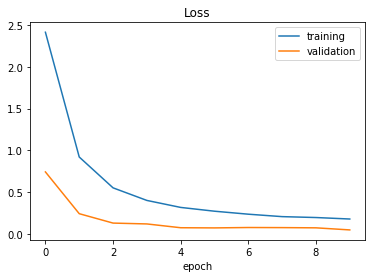

In [15]:
plt.plot(loadedHistory['loss']) 
plt.plot(loadedHistory['val_loss']) 
plt.legend(['training', 'validation']) 
plt.title('Loss') 
plt.xlabel('epoch') 

#### Plotting the Graph (B)

We will now a plot of graph of Accuracy with the number of Epoch

Text(0.5, 0, 'epoch')

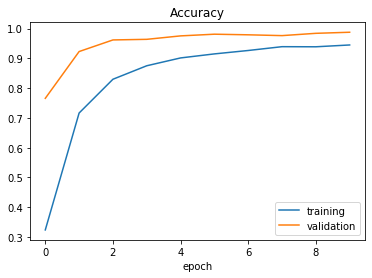

In [16]:
plt.plot(loadedHistory['accuracy']) 
plt.plot(loadedHistory['val_accuracy']) 
plt.legend(['training', 'validation']) 
plt.title('Accuracy') 
plt.xlabel('epoch') 

### Now we verify the Test loss and Accuracy
Here we have it

In [17]:
score = loadedModel.evaluate(X_test, y_test, verbose = 0) 
print('Test Loss: ', score[0]) 
print('Test Accuracy: ', score[1]) 


Test Loss:  0.13286198675632477
Test Accuracy:  0.9627870321273804


### We now test it some testing data

Predicted sign: Speed limit (20km/h)


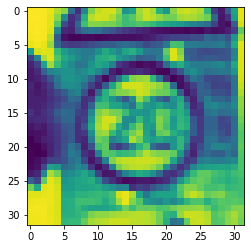

In [20]:
x=990


plt.imshow(X_test[x].reshape(32, 32)) 
print("Predicted sign: "+ df[int( 
            loadedModel.predict_classes(X_test[x].reshape(1, 32, 32, 1)))])
    


Predicted sign: Speed limit (30km/h)


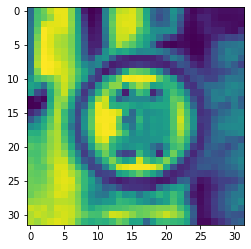

In [21]:
 x=100

plt.imshow(X_test[x].reshape(32, 32)) 
print("Predicted sign: "+ df[int( 
            loadedModel.predict_classes(X_test[x].reshape(1, 32, 32, 1)))])


Predicted sign: Speed limit (100km/h)


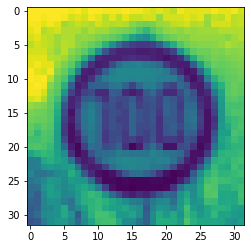

In [22]:
x=150
plt.imshow(X_test[x].reshape(32, 32)) 
print("Predicted sign: "+ df[int( 
            loadedModel.predict_classes(X_test[x].reshape(1, 32, 32, 1)))])

Predicted sign: General caution


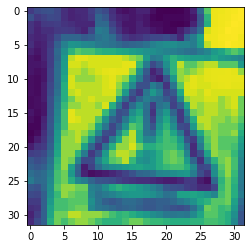

In [23]:
x=275
plt.imshow(X_test[x].reshape(32, 32)) 
print("Predicted sign: "+ df[int( 
            loadedModel.predict_classes(X_test[x].reshape(1, 32, 32, 1)))])

Predicted sign: Speed limit (60km/h)


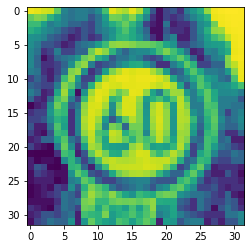

In [24]:
x=420
plt.imshow(X_test[x].reshape(32, 32)) 
print("Predicted sign: "+ df[int( 
            loadedModel.predict_classes(X_test[x].reshape(1, 32, 32, 1)))])